<a href="https://colab.research.google.com/github/gwangjinjeong/Pytorch/blob/master/basic/01_Differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*0. Preparation*

In [0]:
import torch 
import matplotlib.pylab as plt

#*1. Derivatives*

***Tensor***   
패키지의 중심에는 `torch.Tensor` 클래스가 있습니다. 만약 `.requires_grad` 속성을 **True** 로 설정하면, 그 **tensor**에서 이뤄진 모든 연산들을 추적(track)하기 시작합니다.
   
계산이 완료된 후 `.backward()` 를 호출하여 모든 변화도(gradient)를 자동으로 계산할 수 있습니다. 이 Tensor의 변화도는 .grad 속성에 누적됩니다.

.requires_grad_( ... ) 는 기존 Tensor의 requires_grad 값을 바꿔치기 (in-place)하여 변경합니다. 입력값이 지정되지 않으면 기본값은 False 입니다.   
$y=x^{2}+2x+1$ 를 계산해본다면..

In [143]:
x = torch.tensor(2.0, requires_grad = True)
print(x)
y = x ** 2 + 2 * x + 1
print(y)

tensor(2., requires_grad=True)
tensor(9., grad_fn=<AddBackward0>)


도함수를 계산하기 위해서는 Tensor 의 `.backward()` 를 호출하면 됩니다.   
만약 Tensor 가 스칼라(scalar)인 경우(예. 하나의 요소 값만 갖는 등)에는 `backward` 에 인자를 정해줄 필요가 없습니다.   
 하지만 여러 개의 요소를 갖고 있을 때는 tensor의 모양을 gradient 의 인자로 지정할 필요가 있습니다.

$y=x^{2}+2x+1$

In [144]:
# Calculate the y = x^2 + 2x + 1, then find the derivative 
x = torch.tensor(2.0, requires_grad = True)
y = x ** 2 + 2 * x + 1
print(y)
y.backward()
print(x.grad)

tensor(9., grad_fn=<AddBackward0>)
tensor(6.)


$\frac{\mathrm{dy(x)}}{\mathrm{dx}}=2x+2$

$\frac{\mathrm{dy(x=2)}}{\mathrm{dx}}=2(2)+2=6$

##1.1 Partial Derivatives

$f(u,v)=vu+u^{2}$

In [145]:
u = torch.tensor(1.0,requires_grad=True)
v = torch.tensor(2.0,requires_grad=True)
f = u * v + u ** 2
print(f)

tensor(3., grad_fn=<AddBackward0>)


$f(u=1,v=2)=(2)(1)+1^{2}=3$

`u` 편미분값 과 `v`편미분 한 값

In [146]:
f.backward()
print(u.grad)

tensor(4.)


$\frac{\mathrm{\partial f(u,v)}}{\partial {u}}=v+2u$

$\frac{\mathrm{\partial f(u=1,v=2)}}{\partial {u}}=2+2(1)=4$

$\frac{\mathrm{\partial f(u,v)}}{\partial {v}}=u$

$\frac{\mathrm{\partial f(u=1,v=2)}}{\partial {v}}=1$

##1.2 detach


   
Tensor가 기록을 추적하는 것을 중단하게 하려면, `.detach()` 를 호출하여 연산 기록으로부터 분리(detach)하여 이후 연산들이 추적되는 것을 방지할 수 있습니다.

In [0]:
x = torch.linspace(-10, 10, 10, requires_grad = True)
Y = x ** 2
y = torch.sum(x ** 2)

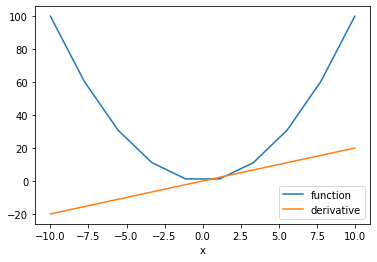

In [148]:
y.backward()

plt.plot(x.detach().numpy(), Y.detach().numpy(), label = 'function')
plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label = 'derivative')
plt.xlabel('x')
plt.legend()
plt.show()

`relu`를 예로 들어보자

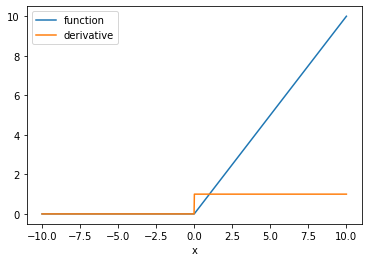

In [149]:
x = torch.linspace(-10, 10, 1000, requires_grad = True)
Y = torch.relu(x)
y = Y.sum()
y.backward()
plt.plot(x.detach().numpy(), Y.detach().numpy(), label = 'function')
plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label = 'derivative')
plt.xlabel('x')
plt.legend()
plt.show()


기록을 추적하는 것(과 메모리를 사용하는 것)을 방지하기 위해, 코드 블럭을 `with torch.no_grad():` 로 감쌀 수 있습니다. 이는 특히 변화도(gradient)는 필요없지만, requires_grad=True 가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)할 때 유용합니다.

**Autograd** 구현에서 매우 중요한 클래스가 하나 더 있는데, 이것은 바로 `Function` 클래스입니다.

`Tensor` 와 `Function` 클래스는 서로 연결되어 있으며, 모든 연산 과정을 부호화(encode)하여 순환하지 않는 그래프(acyclic graph)를 생성합니다. 각 tensor는 `.grad_fn` 속성을 갖고 있는데, 이는 `Tensor` 를 생성한 Function 을 참조하고 있습니다. (단, 사용자가 만든 Tensor는 예외로, 이 때 `grad_fn` 은 None 입니다.)

#*2. Hypothesis and Cost*

기본적으로 ML에서 무언가를 예측하고자 할때, 가설과 이 가설이 얼마나 잘 예측했는지 위한 Cost로 나뉜다.    
이는 다음과 같이 표시할 수 있다.
* Hypothesis   

   $ H(x) = Wx + b $    
   
* Cost   

   $cost(W, b) = \frac{1}{m} \sum^m_{i=1} \left( H(x^{(i)}) - y^{(i)} \right)^2 $

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 2.1 Make the trainset(x,y)

$ y = 2x + 1$   
을 input과 output값만을 통해 예측해보자

In [0]:
x = torch.FloatTensor([[1], [2], [3]])
y = torch.FloatTensor([[3], [5], [7]])

In [152]:
print(x)
print(x.shape)

tensor([[1.],
        [2.],
        [3.]])
torch.Size([3, 1])


In [153]:
print(y)
print(y.shape)

tensor([[3.],
        [5.],
        [7.]])
torch.Size([3, 1])


In [154]:
W = torch.tensor(1.0, requires_grad = True)
b = torch.tensor(1.0, requires_grad=True) # 상수를 나타낸다.
print(W,b)

tensor(1., requires_grad=True) tensor(1., requires_grad=True)


In [155]:
hypothesis = x * W + b
print(hypothesis)

tensor([[2.],
        [3.],
        [4.]], grad_fn=<AddBackward0>)


   $cost(W, b) = \frac{1}{m} \sum^m_{i=1} \left( H(x^{(i)}) - y^{(i)} \right)^2 $

In [156]:
cost = torch.mean((hypothesis - y) ** 2)
print(cost)

tensor(4.6667, grad_fn=<MeanBackward0>)


그냥 계산을 하면 Cost가 매우 큰것을 볼 수 있다.   
이 Cost가 최소화된, 즉 예측값이 실제값과 동일할때 까지 optimize 과정을 거쳐야한다.   
 이때 대표적으로 Gradient Descent를 사용한다.

## 2.2 Gradient Descent

Cost를 미분을 했을때, 값이 0인 즉, 기울기가 0인 값이 최적이라고 볼 수 있다.

이를 위해서 미분한값이 음수 이면 W값을 늘리고, 양수이면 W값을 줄인다.   
이를 다음과 같이 나타낼수 있다.   


$W := W-\alpha\frac{\mathrm{dcost}}{\mathrm{dW}}$   
여기서 $\alpha$는 learning rate를 나타내며   
$\frac{\mathrm{dcost}}{\mathrm{dW}}$는 Cost의 Gradient를 구한값이다.

In [0]:
optimizer = optim.SGD([W, b], lr=0.01)

`optimizer.zero_grad()`로 gradient를 0으로 초기값 설정.      
`cost.backward()`는 cost를 미분하여 gradient를 계산.   
`optimizer.step()`으로 gradient descent를 진행한다.   

In [0]:
optimizer.zero_grad()
cost.backward()
optimizer.step()

In [159]:
print(W)
print(b)

tensor(1.0933, requires_grad=True)
tensor(1.0400, requires_grad=True)


Let's check if the hypothesis is now better.

이제 linear regression 모델을 만들면 되는데,   
기본적으로 PyTorch의 모든 모델은 제공되는 `nn.Module`을 상속시켜서 만들게 됩니다.

In [0]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x): # Hypothesis계산을 해준다.
        return self.linear(x)

모델의 `__init__`에서는 사용할 레이어들을 정의하게 됩니다. 여기서 우리는 linear regression 모델을 만들기 때문에, `nn.Linear` 를 이용할 것입니다. 그리고 `forward`에서는 이 모델이 어떻게 입력값에서 출력값을 계산하는지 알려줍니다.

In [0]:
x = torch.FloatTensor([[1], [2], [3]])
y = torch.FloatTensor([[3], [5], [7]])

In [0]:
model = LinearRegressionModel()

In [163]:
# 모델 초기화
model = LinearRegressionModel()

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.01)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):
    
    # H(x) 계산
    prediction = model(x)
    
    # cost 계산
    cost = F.mse_loss(prediction, y)
    
    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 100번마다 로그 출력
    if epoch % 100 == 0:
        params = list(model.parameters())
        W = params[0].item()
        b = params[1].item()
        print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
            epoch, nb_epochs, W, b, cost.item()
        ))

Epoch    0/1000 W: -0.328, b: -0.701 Cost: 55.697922
Epoch  100/1000 W: 2.196, b: 0.554 Cost: 0.028664
Epoch  200/1000 W: 2.154, b: 0.649 Cost: 0.017713
Epoch  300/1000 W: 2.121, b: 0.724 Cost: 0.010945
Epoch  400/1000 W: 2.095, b: 0.783 Cost: 0.006764
Epoch  500/1000 W: 2.075, b: 0.830 Cost: 0.004179
Epoch  600/1000 W: 2.059, b: 0.866 Cost: 0.002583
Epoch  700/1000 W: 2.046, b: 0.895 Cost: 0.001596
Epoch  800/1000 W: 2.036, b: 0.917 Cost: 0.000986
Epoch  900/1000 W: 2.029, b: 0.935 Cost: 0.000609
Epoch 1000/1000 W: 2.022, b: 0.949 Cost: 0.000377


이로써 W는 2와 가깝게, b는 1과 가깝게 된것을 볼 수 있습니다.

# *3. Multivariable Linear regression*

$$ H(x_1, x_2, x_3) = x_1w_1 + x_2w_2 + x_3w_3 + b $$

$$ cost(W, b) = \frac{1}{m} \sum^m_{i=1} \left( H(x^{(i)}) - y^{(i)} \right)^2 $$

 - $H(x)$: 주어진 $x$ 값에 대해 예측을 어떻게 할 것인가
 - $cost(W, b)$: $H(x)$ 가 $y$ 를 얼마나 잘 예측했는가

## 3.1 Make the trainset(x1,x2,x3,y)

In [0]:
# 데이터
x_train = torch.FloatTensor([[73, 80, 75],
                             [93, 88, 93],
                             [89, 91, 90],
                             [96, 98, 100],
                             [73, 66, 70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])


## 3.2 Load the linear model for multivariable

In [0]:
class MultivariateLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)

    def forward(self, x):
        return self.linear(x)

In [166]:
# 모델 초기화
model = MultivariateLinearRegressionModel()
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=1e-5)

nb_epochs = 1000
for epoch in range(nb_epochs+1):
    
    # H(x) 계산
    prediction = model(x_train)
    
    # cost 계산
    cost = F.mse_loss(prediction, y_train)
    
    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 100번마다 로그 출력
    if epoch % 100 == 0:
        params = list(model.parameters())
        w1 = params[0][0][0]
        w2 = params[0][0][1]
        w3 = params[0][0][2]
        b = params[1]
        print('Epoch {:4d}/{} w1: {:.3f} w2: {:.3f} w3: {:.3f} b: {:.3f} Cost: {:.6f}'.format(
            epoch, nb_epochs, w1.item(), w3.item(), w3.item(), b.item(), cost.item()
        ))

Epoch    0/1000 w1: 0.525 w2: 0.442 w3: 0.442 b: -0.383 Cost: 24433.072266
Epoch  100/1000 w1: 0.864 w2: 0.785 w3: 0.785 b: -0.379 Cost: 0.486605
Epoch  200/1000 w1: 0.863 w2: 0.783 w3: 0.783 b: -0.379 Cost: 0.482876
Epoch  300/1000 w1: 0.863 w2: 0.782 w3: 0.782 b: -0.378 Cost: 0.479266
Epoch  400/1000 w1: 0.863 w2: 0.781 w3: 0.781 b: -0.378 Cost: 0.475791
Epoch  500/1000 w1: 0.862 w2: 0.780 w3: 0.780 b: -0.378 Cost: 0.472443
Epoch  600/1000 w1: 0.862 w2: 0.779 w3: 0.779 b: -0.378 Cost: 0.469209
Epoch  700/1000 w1: 0.862 w2: 0.778 w3: 0.778 b: -0.378 Cost: 0.466090
Epoch  800/1000 w1: 0.862 w2: 0.777 w3: 0.777 b: -0.378 Cost: 0.463067
Epoch  900/1000 w1: 0.862 w2: 0.776 w3: 0.776 b: -0.378 Cost: 0.460149
Epoch 1000/1000 w1: 0.861 w2: 0.775 w3: 0.775 b: -0.377 Cost: 0.457325
